In [1]:
import torch
from torch import nn

In [3]:
neuron = nn.Linear(in_features=5, out_features=1, bias=True)

Linear(in_features=5, out_features=1, bias=True)

In [6]:
X = torch.rand(5)
y = neuron(X)
y

tensor([0.1226], grad_fn=<ViewBackward0>)

In [21]:
print(X)
print(neuron.weight)

torch.sum(neuron.weight * X) + neuron.bias

tensor([0.5076, 0.2397, 0.1468, 0.1769, 0.7200])
Parameter containing:
tensor([[-0.1216,  0.0819, -0.2786,  0.0135,  0.0125]], requires_grad=True)


tensor([0.3596], grad_fn=<AddBackward0>)

In [25]:
pair = nn.Linear(5, 2)
deep_layer = nn.Linear(2, 10)

x = pair(X)
x = deep_layer(x)
x

tensor([ 0.4817, -0.1418,  0.4010,  0.3839, -0.3303,  0.0893, -0.5383,  0.0504,
         0.7048,  0.1630], grad_fn=<AddBackward0>)

In [30]:
batch = torch.rand(100, 5)
print(pair(batch).size())

torch.Size([100, 2])


In [35]:
class Net(nn.Module):
    # Первый аргумент метода класса - всегда self, т.е. указание на объект
    def __init__(self):
        super(Net, self).__init__() # Вызов конструктора родителя
        
        # Описание архитектуры сети
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)
    
    # Метод, который описывает прямой проход, т.е. порядок следования слоёв
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x
    
    
net = Net() # Создаём экземпляр класса Net, т.е. конкретный чёрный ящик
# model = DecisionTreeClassifier(могут быть параметры) - аналогия с scikit

batch = torch.rand(100, 128)
y = net(batch)

print(y.size())

torch.Size([100, 1])


# MNIST Digits

In [ ]:
# Качаем датасеты
train_url = 'http://istrm.cf/ml/mnist_train.tar.gz'
test_url = 'http://istrm.cf/ml/mnist_test.tar.gz'

!wget $train_url $test_url

In [ ]:
# Распаковываем их (для тех, кто работает на своём компьютере на Windows - разархивировать вручную)

!tar -xf ./mnist_train.tar.gz
!tar -xf ./mnist_test.tar.gz

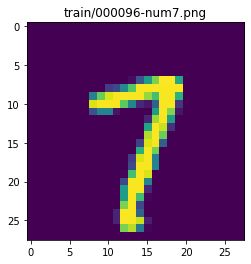

In [53]:
# Пощупаем датасеты

from pathlib import Path
import matplotlib.pyplot as plt

train_dir = Path('./train')  # Указание на папку
glob = train_dir.glob("*.png") # Поиск внутри папки по шаблону *.png
train_srcs = list(glob) # Список всех файлов для обучения

# То же самое для валидационных примеров
val_dir = Path('./test')  
glob = val_dir.glob("*.png")
val_srcs = list(glob) 

i = 0
img = plt.imread(train_srcs[i])
plt.imshow(img)
plt.title(train_srcs[0]);

In [59]:
src = train_srcs[0]

int(str(src)[-5]) + 5

12

In [67]:
from torch.utils.data import Dataset, DataLoader

# Это класс, который определяет датасет
# Он хранит в себе обучающие объекты: (признаки, ответы)

class myDataset(Dataset):
    def __init__(self, srcs):
        self.imgs = [] # Сюда будем складывать загруженный картинки
        self.answers = [] # Сюда будем складывать ответы
        
        for src in srcs:
            img = plt.imread(src).ravel() # Делаем из двумерного изображения - одномерное
            self.imgs.append(img)
            
            ans = int(str(src)[-5])  # Берём ответ из названия файла и преобразуем его в число
            self.answers.append(ans)
            
        self.srcs = srcs
    
    # Обязательно нужно явно прописать размер датасета
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, item):
        x = self.imgs[item]
        ans = self.answers[item]
        
        return x, ans

In [77]:
train_dataset = myDataset(train_srcs)
val_dataset = myDataset(val_srcs)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [82]:
for batch in val_loader:
    break

x_batch, y_batch = batch

y_batch

tensor([5, 3, 8, 2, 5, 8, 0, 7, 8, 2, 1, 9, 9, 7, 3, 2, 3, 5, 8, 3, 9, 1, 8, 5,
        5, 4, 8, 0, 4, 8, 8, 8, 3, 5, 0, 8, 9, 6, 8, 2, 3, 1, 6, 6, 5, 3, 5, 5,
        3, 6, 1, 6, 7, 8, 5, 9, 2, 4, 9, 6, 5, 8, 6, 3])

In [109]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        
        # Описание архитектуры сети
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # На последнем слое кол-во нейронов должно совпадать с кол-вом классов
        
        self.softmax = nn.Softmax(dim=1)  # dim=1 значит, что нормировка будет идти в строке (по столбцу)
        
    # Метод, который описывает прямой проход, т.е. порядок следования слоёв
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        x = self.softmax(x)  # Нормировка выхода на 1
        
        return x

In [129]:
from tqdm.notebook import tqdm
import numpy as np

# Создаём модель
model = MNISTNet()  # Модель будет вычислять на процессоре
model = model.cuda()  # .cuda() переносит её на видеокарту

# Создаём оптимизатор. В о. передаются:
# * Параметры модели. Т.е. те веса, которые должны в ходе обучения поменять
# model.parameters()
# * lr - learning rate - гиперпараметр, который указывает с какой "интенсивностью" менять веса
# По собственному опыту, 0.001 для Adam часто приводит к хорошему результату
# * weigt_decay - это коэффициент L2-регулярзации, которые используется для борьбы с переобучение
# чем он больше - тем меньше вероятность переобучиться. 
# По собственному опыту - 1e-5 до 1e-3 (слабое, но верное и серёьзное, но на некоторых данных может сломать)

optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

# Один проход через весь датасет (60000 / 64 (размер батча) = Х батчей) - называет эпохой

loss_dict = dict(train=[], val=[])

for epoch in tqdm(range(100)): # Допустим, будем учить 100 эпох
    for phase in ['train', 'val']:
        if phase == 'train':
            model = model.train()  # Переводим модель в режим обучения
            loader = train_loader
            torch.set_grad_enabled(True)  # Заставляем модель сохранять градиенты (это необходимо для обуч.)
        else:
            model = model.eval()  # Переводим модель в режим исполнения
            loader = val_loader
            torch.set_grad_enabled(False)
        
        running_loss = []
        for batch in loader:
            X, y = batch  # Вынимаем признаки и ответы
            
            # И переносим их в видеопамять
            X = X.cuda()
            y = y.cuda()
            predictions = model(X)
            
            loss = loss_fn(predictions, y)  # Считаем функцию потерь
            
            running_loss.append(loss.item())
            if phase == 'val':
                continue
                
            optim.zero_grad() # Для того, чтобы обновить веса
            loss.backward()   # Нужно выполнить последовательно эти три команды
            optim.step()      # Веса мы обновляем только на обучении
            
        # Закончили проход по данным
        mean_loss = np.mean(running_loss)
        loss_dict[phase].append(mean_loss)

In [173]:
# Обученые веса модели хранятся в атрибуте .state_dict()
state_dict = model.state_dict()

# Чтобы его сохранить в файл используется команда torch.save()

torch.save(state_dict, 'mnist_1.pt')

In [186]:
# Как подгрузить

# Создали модель с нуля
new_model = MNISTNet()
new_model = new_model.cuda()

pretrained_state = torch.load('mnist_1.pt')
new_model.load_state_dict(pretrained_state)

# После загрузки модели её нужно переводить в eval()
# Если на видеокарте - то model = model.cuda()
new_model = new_model.eval()

# Проверка результатов

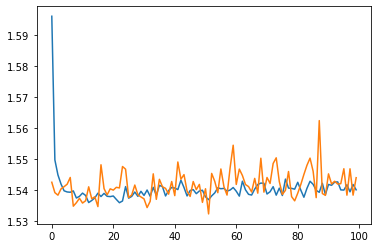

In [130]:
import matplotlib.pyplot as plt

plt.plot(loss_dict['train'])
plt.plot(loss_dict['val'])

In [187]:
loader = val_loader

p = []  # Сюда предсказания
a = []  # Сюда правильные ответы

for batch in loader:
    X, y = batch  # Вынимаем признаки и ответы

    # И переносим их в видеопамять
    X = X.cuda()
    y = y.cuda()
    predictions = new_model(X)
    
    p.append(predictions)
    a.append(y)

In [188]:
# Объединение
cat_p = torch.cat(p)
cat_a = torch.cat(a)

# Достанем из видеопамяти
cat_p = cat_p.detach().cpu().numpy()
cat_a = cat_a.detach().cpu().numpy()

pred = cat_p.argmax(axis=1)  # Ищем индекс максимального элемента
ans = cat_a

In [189]:
np.mean(pred == ans)

0.9172

In [156]:
# Ищем примеры, на которых модель ошиблась

err = pred != ans # Маска ошибок
err_index = np.where(err)[0]

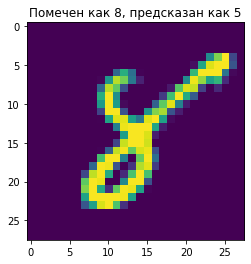

In [170]:
i = 10

X, y = val_dataset[err_index[i]]
pred_on_element = pred[err_index[i]]
X = X.reshape(28, 28)  # Снова делаем двумерное изображение

plt.imshow(X)
plt.title("Помечен как " + str(y) + ", предсказан как " + str(pred_on_element));